In [99]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
from jax import jit, vmap, grad
from jax.scipy.special import erfc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')
from exojax.scipy.special import erfcx, rewofz, imwofz, rewofzx, rewofz_ej2, rewofzs2
from exojax.scipy._special import rewofzs1,  rewofzs3

from jax.interpreters.ad import defvjp
from jax import custom_vjp

import seaborn as sns
import matplotlib.pyplot as plt
import arviz

import numpy as np
import jax.numpy as jnp
from jax import random
from jax.lax import map

import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

from jax.interpreters import batching
from jax import abstract_arrays
from jax.lib import xla_client
from jax.interpreters import xla
from jax import core
from jax.interpreters import ad
import numpy as np  
from jax.core import Primitive
from jax.interpreters.ad import defvjp

from jax.lax import scan

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#errorはn2 + x*x ででてる 27, 20 -> 27, (27,20)


In [27]:
import numpy as np
a=np.array([1,2,3])
x=np.array([0,1])
Y=(a[:,None]+x[None,:])
Y.T@Y, a@a, (a+1)@(a+1)
np.sum(Y*Y,axis=0), a@a, (a+1)@(a+1), np.sum(a*a,axis=0)

(array([14, 29]), 14, 29, 14)

In [30]:
a@a,a@(a+1)

(14, 20)

In [37]:
Y=(a[None,:]+x[:,None])
np.sum(a*Y,axis=1)

array([14, 20])

In [106]:
def rewofz_ud(x, y):
    ncut=27
    xy=x*y
    xyp=xy/jnp.pi
    exx=jnp.exp(-x*x)
    f=exx*erfcx(y)*jnp.cos(2.0*xy)+x*jnp.sin(xy)/jnp.pi*exx*jnp.sinc(xyp)
    n=jnp.arange(1,ncut+1)
    n2=n*n
    x2=x*x
    y2=y*y
    vec0=1.0/(0.25*n2+y2)
    vec1=jnp.exp(-(0.25*n2[None,:]+x2[:,None]))
    vec2=jnp.exp(-(0.5*n[None,:]+x[:,None])*(0.5*n[None,:]+x[:,None]))
    vec3=jnp.exp(-(0.5*n[None,:]-x[:,None])*(0.5*n[None,:]-x[:,None]))
    Sigma1=jnp.sum(vec0*vec1,axis=1)
    Sigma2=jnp.sum(vec0*vec2,axis=1)
    Sigma3=jnp.sum(vec0*vec3,axis=1)
    
    f = f + 1.0/jnp.pi*(-y*jnp.cos(2.0*xy)*Sigma1 + 0.5*y*Sigma2 + 0.5*y*Sigma3)
    return f

def imwofz_ud(x, y):
    ncut=27
    xy=x*y
    xyp=2.0*xy/jnp.pi
    exx=jnp.exp(-x*x)
    f=-exx*erfcx(y)*jnp.sin(2.0*xy)+x/jnp.pi*exx*jnp.sinc(xyp)
    n=jnp.arange(1,ncut+1)
    n2=n*n
    x2=x*x
    y2=y*y
    vec0=0.5*n/(0.25*n2+y2)
    vec1=jnp.exp(-(0.25*n2[None,:]+x2[:,None]))
    vec4=jnp.exp(-(0.5*n[None,:]+x[:,None])*(0.5*n[None,:]+x[:,None]))
    vec5=jnp.exp(-(0.5*n[None,:]-x[:,None])*(0.5*n[None,:]-x[:,None]))
    Sigma1=jnp.sum(vec0*vec1,axis=1)
    Sigma4=jnp.sum(vec0*vec4,axis=1)
    Sigma5=jnp.sum(vec0*vec5,axis=1)
    f = f + 1.0/jnp.pi*(y*jnp.sin(2.0*xy)*Sigma1 + 0.5*(Sigma5-Sigma4))

    return f


def rewofzc(x,y):
    return foo_p.bind(x,y)
foo_p = Primitive('rewofz')
foo_p.def_impl(rewofz)

def drewofzc(g, x, y):
    V=rewofz(x,y)
    L=imwofz(x,y)
    return 2.0 * (y*L - x*V) * g , 2.0 * (x*L + y*V) * g - 2.0/jnp.sqrt(jnp.pi)
defvjp(foo_p, drewofzc)

def foo_batch(vector_arg_values, batch_axes):
    res = rewofzc(*vector_arg_values)
    return res, batch_axes[0]

batching.primitive_batchers[foo_p] = foo_batch


In [161]:
from jax import custom_vjp
@custom_vjp
def rewofzc(x, y):
    return rewofz(x, y)

def h_fwd(x, y):
    hh=rewofz(x, y)
    return hh, (x,y) #(hh, imwofz(x, y), x, y)

def h_bwd(res, g):
    #V, L, x, y = res
    x, y=res
    V=rewofz(x, y)
    L=imwofz(x, y)
    return (2.0 * (y*L - x*V) * g , (2.0 * (x*L + y*V)  - 2.0/jnp.sqrt(jnp.pi)) * g )

rewofzc.defvjp(h_fwd, h_bwd)



In [153]:
@jit
def VoigtRewofzx(nu,sigmaD,gammaL):
    sfac=1.0/(jnp.sqrt(2)*sigmaD)
    #v=sfac*rewofz(sfac*nu,sfac*gammaL)/jnp.sqrt(jnp.pi)
    #v=sfac*rewofz_ud(sfac*nu,sfac*gammaL)/jnp.sqrt(jnp.pi)
    v=sfac*rewofzc(sfac*nu,sfac*gammaL)/jnp.sqrt(jnp.pi)
    return v

@jit
def FAbsVRewofzx(nu,sigmaD,gammaL,A):
    tau=A*VoigtRewofzx(nu,sigmaD,gammaL)
    f=jnp.exp(-tau)
    return f


In [154]:
xv=jnp.linspace(-1,1,3)
#FAbsVRewofzx(xv,1.0,2.0,4.0)

In [155]:
# generating mock absorption data
np.random.seed(34)
N=20
nuarr=jnp.linspace(-10,10,N)
sigin=0.01
sDfix = jnp.array(1.0)
gLfix = jnp.array(0.5)
Afix = jnp.array(1.0)
nu0fix = 0.7
vFAbsVRewofzx=vmap(FAbsVRewofzx,(0,None,None,None),0)
data=vFAbsVRewofzx(nuarr-nu0fix,sDfix,gLfix,Afix)+np.random.normal(0,sigin,size=N)
#data=FAbsVRewofzx(nuarr-nu0fix,sDfix,gLfix,Afix)+np.random.normal(0,sigin,size=N)

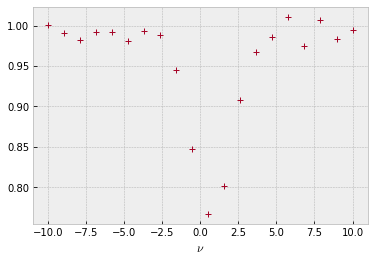

In [156]:
# Here is a mock dataset
plt.plot(nuarr,data,"+",color="C1")
plt.xlabel("$\\nu$")
plt.show()

In [157]:
sDfix,gLfix,Afix

(DeviceArray(1., dtype=float32),
 DeviceArray(0.5, dtype=float32),
 DeviceArray(1., dtype=float32))

In [158]:
#probabilistic model using numpyro
def model(nu,y):
    A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sD = numpyro.sample('sD', dist.Exponential(1.))
    gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    nu0 = numpyro.sample('nu0', dist.Uniform(-5,5))
    mu = vFAbsVRewofzx(nu-nu0,(sD),(gL),(A))
    #mu = FAbsVRewofzx(nu-nu0,0.3556425, 0.2640675, 1.0725802)
    #mu = FAbsVRewofzx(nu-nu0,1.0,0.5,1.0)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [159]:
np.shape(nuarr),np.shape(data)

((20,), (20,))

In [160]:
# OK, a HMC-NUTS!
# Our model, lpf.FAbsVRewofz, is compatible to jax. Autograd works. We can perform a HMC-NUTS.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nuarr, y=data)
mcmc.print_summary()

  0%|          | 0/3000 [00:00<?, ?it/s]


AssertionError: length mismatch: [1, 4]

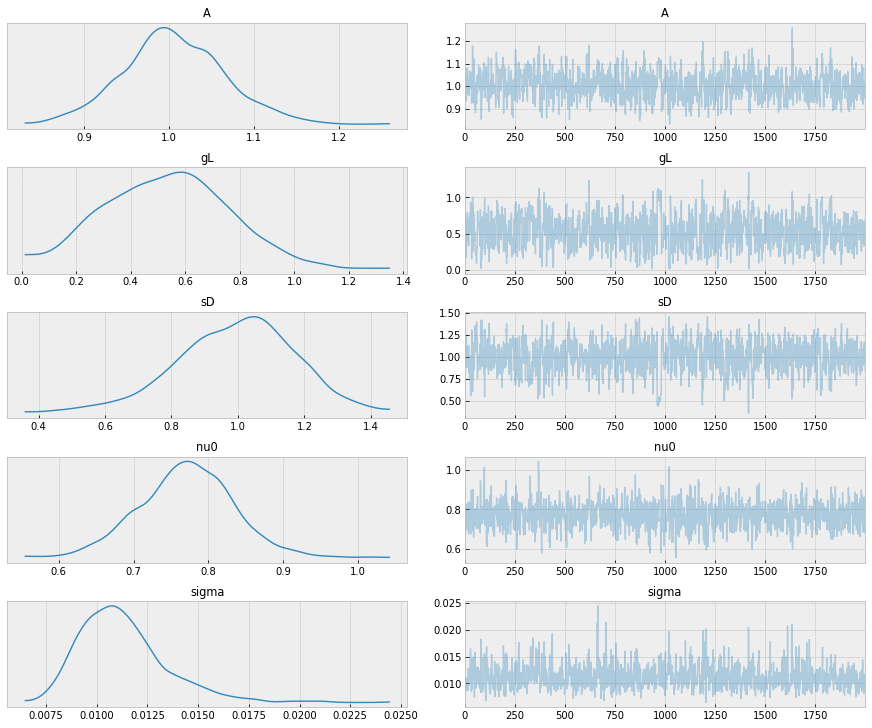

In [74]:
import arviz
#arviz is superuseful to check chains
arviz.plot_trace(mcmc, var_names=["A", "gL", "sD","nu0","sigma"])
plt.show()

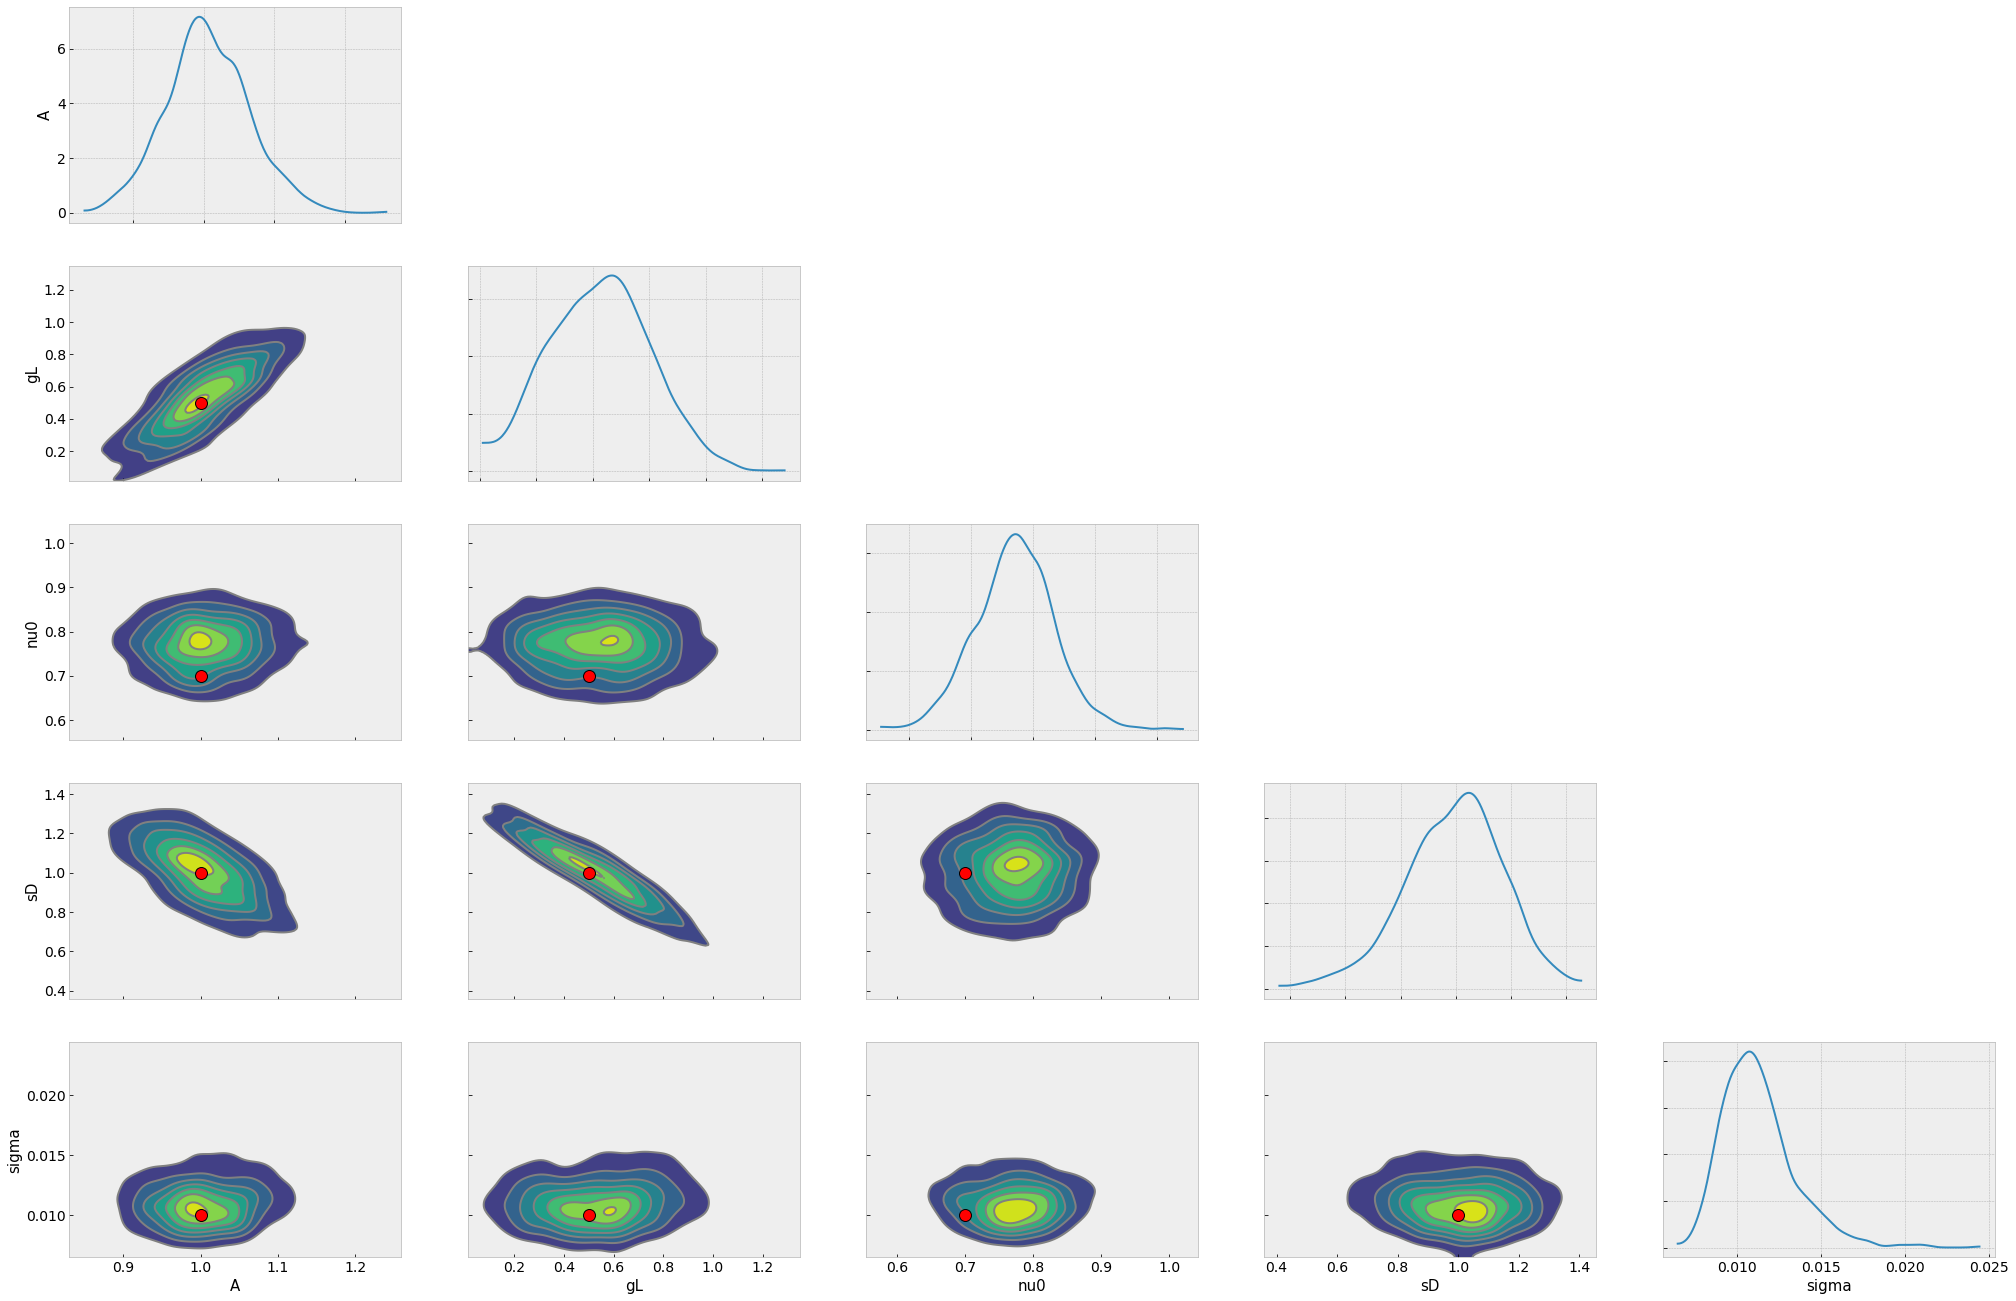

In [75]:
#cool and flexible corner plot in arviz. You can also try kind='hexbin' instead of 'kde' for instance.
#arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=True)
refs={}
refs["A"]=Afix
refs["sD"]=sDfix
refs["gL"]=gLfix
refs["sigma"]=sigin
refs["nu0"]=nu0fix
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.show()

In [76]:
# generating predictions
# hpdi is "highest posterior density interval"
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = jnp.linspace(-12,12,100)
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

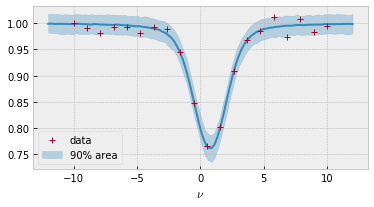

In [77]:
# final plot of median and 90% credible area of the prediction

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(nu_,median_mu,color="C0")
ax.plot(nuarr,data,"+",color="C1",label="data")
ax.fill_between(nu_, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$\\nu$")
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_absorption_.png")
plt.show()